# Named Entity Recognition

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

In [4]:
ner_train_path = tf.keras.utils.get_file('ner_train.txt', 'https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/refs/heads/master/neuroner/data/conll2003/en/train.txt')
ner_test_path = tf.keras.utils.get_file('ner_test.txt', 'https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/refs/heads/master/neuroner/data/conll2003/en/test.txt')

3283420/3283420 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
748095/748095 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 데이터 전처리

1. (word, ner) 변환
2. 토큰화
3. sequence 처리
4. padding 처리

In [5]:
# (word, ner) 태깅
def get_tagged_sentences(path):
    temp = []
    sentences = []
    
    for line in open(path, 'r', encoding='utf-8'):
        if line.startswith('-DOCSTART') or line[0] == '\n':
            if len(temp) > 0:
                sentences.append(temp)
                temp = []
            continue
    
        word, pos, chunk, ner = line.split()
        ner = re.sub('\n', '', ner)
        word = word.lower()
        temp.append((word, ner))
        
    return sentences

In [6]:
train_tagged_sents = get_tagged_sentences(ner_train_path)
test_tagged_sents = get_tagged_sentences(ner_test_path)

train_tagged_sents[:5]

[[('eu', 'B-ORG'),
  ('rejects', 'O'),
  ('german', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('peter', 'B-PER'), ('blackburn', 'I-PER')],
 [('brussels', 'B-LOC'), ('1996-08-22', 'O')],
 [('the', 'O'),
  ('european', 'B-ORG'),
  ('commission', 'I-ORG'),
  ('said', 'O'),
  ('on', 'O'),
  ('thursday', 'O'),
  ('it', 'O'),
  ('disagreed', 'O'),
  ('with', 'O'),
  ('german', 'B-MISC'),
  ('advice', 'O'),
  ('to', 'O'),
  ('consumers', 'O'),
  ('to', 'O'),
  ('shun', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('until', 'O'),
  ('scientists', 'O'),
  ('determine', 'O'),
  ('whether', 'O'),
  ('mad', 'O'),
  ('cow', 'O'),
  ('disease', 'O'),
  ('can', 'O'),
  ('be', 'O'),
  ('transmitted', 'O'),
  ('to', 'O'),
  ('sheep', 'O'),
  ('.', 'O')],
 [('germany', 'B-LOC'),
  ("'s", 'O'),
  ('representative', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('european', 'B-ORG'),
  ('union', 'I-ORG'),
  ("'s", 'O'),
  ('vete

In [7]:
def get_sents_and_labels(tagged_sentences):
    inputs, labels = [], []
    
    for sentence in tagged_sentences:
        tokens, ner = zip(*sentence)
        
        inputs.append(list(tokens))
        labels.append(list(ner))
        
    return inputs, labels

In [8]:
train_inputs, train_labels = get_sents_and_labels(train_tagged_sents)
test_inputs, test_labels = get_sents_and_labels(test_tagged_sents)

min-max: 1 - 113
mean: 14.501887329962253
median: 10.0


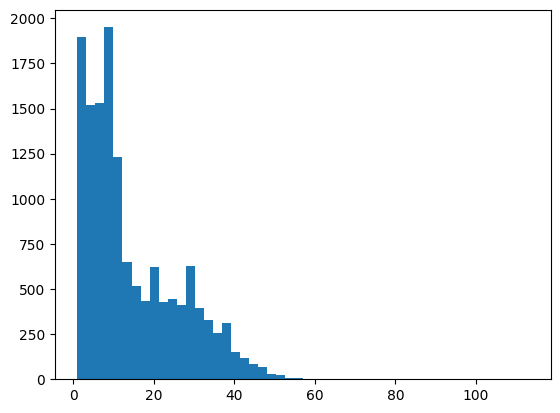

In [9]:
train_len = [len(seq) for seq in train_inputs]

print('min-max:', np.min(train_len), '-', np.max(train_len))
print('mean:', np.mean(train_len))
print('median:', np.median(train_len))

plt.hist(train_len, bins=50)
plt.show()

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_LEN = 50
VOCAB_SIZE = 10000

entity_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_inputs)

X_train = entity_tokenizer.texts_to_sequences(train_inputs)
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='pre', truncating='pre')


In [11]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_labels)

y_train = tag_tokenizer.texts_to_sequences(train_labels)
y_train = pad_sequences(y_train, maxlen=MAX_LEN, padding='pre', truncating='pre')

In [14]:
X_test = entity_tokenizer.texts_to_sequences(test_inputs)
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

y_test = entity_tokenizer.texts_to_sequences(test_labels)
y_test = pad_sequences(y_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

### 모델 생성 및 학습

In [16]:
from tensorflow.keras import layers, models

EMBED_DIM = 100
LATENT_DIM = 256
TAG_SIZE = len(tag_tokenizer.word_index)

input = layers.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE + 1, EMBED_DIM)(input)
lstm = layers.LSTM(LATENT_DIM, return_sequences=True)
x = layers.Bidirectional(lstm)(x)
output = layers.Dense(TAG_SIZE + 1, activation='softmax')(x)

model = models.Model(input, output)
model.summary()

2025-08-22 11:36:28.234465: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-22 11:36:28.234675: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-22 11:36:28.234699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-22 11:36:28.234898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-22 11:36:28.234918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 100)        │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 512)        │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 10)         │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,736,366 (6.62 MB)

 Trainable params: 1,736,366 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-08-22 11:42:49.486966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.9322 - loss: 0.3099 - val_accuracy: 0.9497 - val_loss: 0.2113
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.9574 - loss: 0.1480 - val_accuracy: 0.9626 - val_loss: 0.1299
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.9753 - loss: 0.0823 - val_accuracy: 0.9729 - val_loss: 0.0949
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.9855 - loss: 0.0521 - val_accuracy: 0.9787 - val_loss: 0.0774
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 0.9903 - loss: 0.0359 - val_accuracy: 0.9806 - val_loss: 0.0752
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.9923 - loss: 0.0274 - val_accuracy: 0.9814 - val_loss: 0.0725
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.9939 - loss: 0.0218 - val_accuracy: 0.9804 - val_loss: 0.0720
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.9948 - loss: 0.0185 - val_accuracy: 0.981

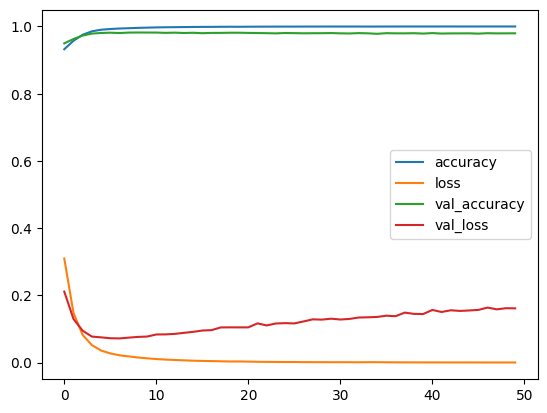

In [17]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split=0.3
)

pd.DataFrame(history.history).plot()
plt.show()

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7422 - loss: 0.5096


(0.5096120834350586, 0.7421720027923584)

### NER 예측

In [21]:
sample = ['Elon Musk is a founder of SpaceX and Neruallink']

sample_seq = entity_tokenizer.texts_to_sequences(sample)
sample_padded = pad_sequences(sample_seq, maxlen=MAX_LEN)

In [22]:
pred_proba = model.predict(sample_padded)

pred = np.argmax(pred_proba, axis=-1)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 1,
        1, 1, 1, 1, 1, 1]])

In [23]:
index2entity = entity_tokenizer.index_word
index2tag = tag_tokenizer.index_word

tokens = [index2entity.get(x, '?') for x in sample_padded[0]]
tags = [index2tag.get(x, '?') for x in pred[0]]

for token, tag in zip(tokens, tags):
    if token != '?':
        print(f'{token} --- {tag}')

<OOV> --- b-per
<OOV> --- i-per
is --- o
a --- o
founder --- o
of --- o
<OOV> --- o
and --- o
<OOV> --- o
